In [8]:
#Programmer: Aisha
#Date: 2/15/2024
#This program uses NASA data to classify space rocks through an AI model

In [2]:
import matplotlib.pyplot as plt 
import numpy as np #processes images

In [3]:
import torch 
from torch import nn, optim 
from torch.autograd import Variable 
import torch.nn.functional as F 

In [4]:
import torchvision # library processes images and alters images; ex. cropping and resizing
from torchvision import datasets, transforms, models 

In [6]:
from PIL import Image # used to visualize images 

In [7]:
#ensures plots are high resolution, shown inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
#Import, clean, and seperate space rock data

data_dir = './Data' # specifies which folder the image data is stored in

# reads the data from folder, crops and resizes all images to 224x224 pixels
# splits data into train and test sets
# function that shuffles images
def load_split_train_test(data_dir, valid_size = .2):

    # uses the transform function to train model on images
    train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.Resize(224), transforms.ToTensor(),])

    # uses the tranform function to test model on images
    test_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.Resize(224), transforms.ToTensor(),])

    # creates two varibales for folders with training and testing images
    train_data = datasets.ImageFolder(data_dir, transform = train_transforms)
    test_data = datasets.ImageFolder(data_dir, transform = test_transforms)

    # retreive number of images in training folder
    num_train = len(train_data)

    # creates a list of numbers from 0 to the number of images for training minus one
    indices = list(range(num_train))

    # finds the index of the image that representa 20% of the data if valid_size is .2
    # Ex. a total of 10 images would result in a split of 2 
    split = int(np.floor(valid_size * num_train)) # Ex. split = int(np.floor(.2 * 10)) -> int(np.floor(2)) -> int(2) -> 2

    # shuffles the indices at random
    np.random.shuffle(indices)

    from torch.utils.data.sampler import SubsetRandomSampler

    # after shuffling the indices, store the first 20% in the training index list
    # store the remaining 80% of shuffled indices into the testing index list
    train_idx, test_idx = indices[split:], indices[:split]

    # creates samplers to get items from the training and testing indices lists at random
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    # create loaders to load 16 images from the train and test data folders 
    # images will be chosen based on the shuffled index lists and by the use of samplers 
    trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = 16)
    testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size = 16)

    # returns the loaders so images can be taken from the training and testing data folders
    return trainloader, testloader

# use load_split_train_test function to:
  # create a trainloader to load 20% of the images
  # create a testloader to load 80% of the images
trainloader, testloader = load_split_train_test(data_dir, .2)

# prints the type of rocks included in the trainloader
print(trainloader.dataset.classes)

['Basalt', 'Highland']


In [18]:
#Transforms and Selects Random Images

# tranforms image into pixels + resizes
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.Resize(224), transforms.ToTensor(),])

# selects a set of images at random, using a similar method to the load_split_train_test function
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform = test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler = sampler, batch_size = num)

    # iterates through shuffled images in the test images dataset 
    dataiter = iter(loader)

    # retreive and return iterated images and labels
    images, labels = dataiter.next()
    return images, labels

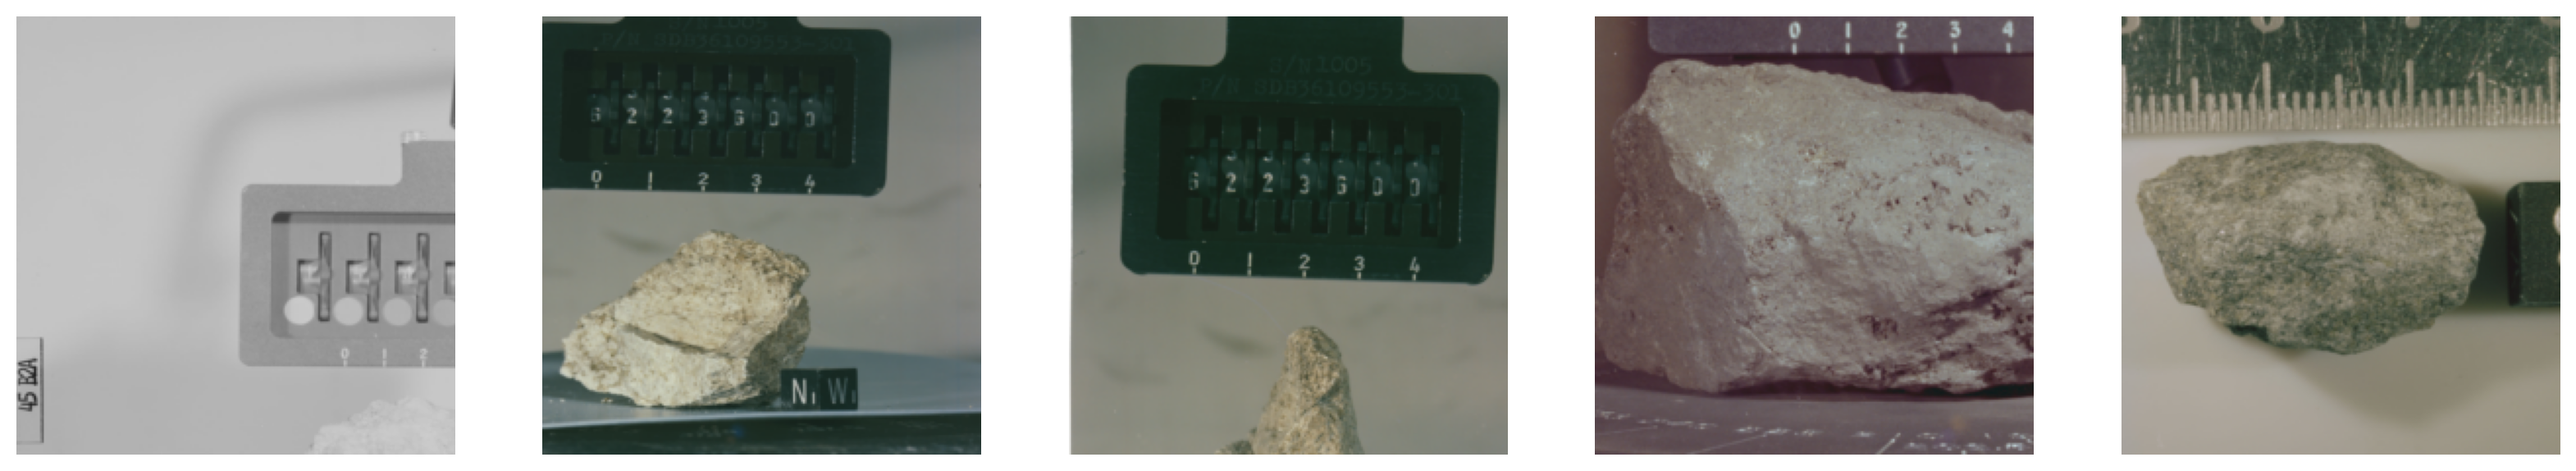

In [24]:
#Shows Randomly Selected Images

# shows five images - adjustable
images, labels = get_random_images(5)

# converts array of pixels to an image
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize = (20, 20))

# retrieves a list of all the classes in the training data
classes = trainloader.dataset.classes

# depicts the images in a plot to display
for ii in range(len(images)):
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii + 1)
    plt.axis('off')
    plt.imshow(image)

# displays all images
plt.show()

In [25]:
# check whether the computer is using a CPU or GPU device to create the deep learning network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained = True)

c:\Users\aisha_7lm59zf\OneDrive\tksrep2env\envs\myenv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\aisha_7lm59zf\OneDrive\tksrep2env\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\aisha_7lm59zf/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100.0%


In [26]:
#builds the neurons in the network
for param in model.parameters():
    param.requires_grad = False

#create the neural network by wiring the neurons
model.fc = nn.Sequential(nn.Linear(2048, 512), nn.ReLU(), nn.Dropout(0.2), nn.Linear(512, 2), nn.LogSoftmax(dim = 1))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.003)

#adds the neural network to device
model.to(device)
print("done")

done


In [32]:
# set the initial number of iterations to search for associations 
epochs = 7
print_every = 7

#initalizes loss variables
running_loss = 0
train_losses, test_losses = [], []

#tracks the current training step, starting at 0
steps = 0

#searches for associations in the features
for epoch in range(epochs):

    #count each epoch 
    epoch += 1

    #load in all image inputs and labels fro the 'train' folder
    for inputs, labels in trainloader:

        #counts each training step through iterating over the step variable
        steps += 1
        print("Training step ", steps)

        #load the inputs and labels to previously selected device 
        inputs, labels = inputs.to(device), labels.to(device)

        #zero out gradients to avoid the accumulation of gradients across training iterations
        optimizer.zero_grad()

        #passes the images through the model, and returns the log probabilities of each label
        logps = model.forward(inputs)

        #run the log probabilities through the criterion to get the output graph
        loss = criterion(logps, labels)

        #uses the loss graph to compute gradients
        loss.backward()

        #updates the parameters based on the current gradient
        optimizer.step()

        #adds the actual loss number to the running (current) loss total
        running_loss += loss.item()

        #evaluates the model after every 5 steps
        if steps % print_every == 0:

            #initialize loss and accuracy 
            test_loss = 0
            accuracy = 0

            #start the model evaluation
            model.eval()

            #refines the accuracy of the prediction without updating the gradients 
            with torch.no_grad():

                #load in all of the images inputs and labels from the 'test' loader
                for inputs, labels in testloader:

                    #load the inputs and labels to the already selected device
                    inputs, labels = inputs.to(device), labels.to(device)

                    #passes the images through the model and returns the log probabilities of each label
                    logps = model.forward(inputs)

                    #runs the log probabilities through the criterion to get the outputted graph
                    batch_loss = criterion(logps, labels)

                    #adds the actual loss number to the running (current) loss total for the test batch
                    test_loss += batch_loss.item()

                    #returns a new tensor with the true probabilities
                    ps = torch.exp(logps)

                    #returns the largest probability and class of the new tensor along a given dimension
                    top_p, top_class = ps.topk(1, dim = 1)

                    #reshapes the tensor to match the same shape as the top class 
                    equals = top_class == labels.view(*top_class.shape)

                    #computes the accuracy and adds it to the running accuracy count for the test batch 
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            #appends the training and testing losses
            train_losses.append(running_loss / len(trainloader))
            test_losses.append(test_loss / len(testloader))

            #display the accuracy of the prediction with 3 digits in the fractional part of the decimal
            print(f"\n     Epoch {epoch}/{epochs}: " f"Train loss: {running_loss/print_every:.3f}.." f"Test loss: {test_loss/len(testloader):.3f}.." f"Test accuracy: {accuracy/len(testloader):.3f}\n")

            #train the model
            running_loss = 0
            model.train()

            #after 5 training steps, the next epoch starts
            # breaks in case trainloader has remaining data
            break

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Training step  6
Training step  7

     Epoch 1/7: Train loss: 0.268..Test loss: 0.211..Test accuracy: 0.902

Training step  8
Training step  9
Training step  10
Training step  11
Training step  12
Training step  13
Training step  14

     Epoch 2/7: Train loss: 0.133..Test loss: 0.069..Test accuracy: 0.969

Training step  15
Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Training step  21

     Epoch 3/7: Train loss: 0.128..Test loss: 0.066..Test accuracy: 1.000

Training step  22
Training step  23
Training step  24
Training step  25
Training step  26
Training step  27
Training step  28

     Epoch 4/7: Train loss: 0.062..Test loss: 0.107..Test accuracy: 0.935

Training step  29
Training step  30
Training step  31
Training step  32
Training step  33
Training step  34
Training step  35

     Epoch 5/7: Train loss: 0.117..Test loss: 0.055..Test accuracy: 1.000


In [30]:
#show the model accuracy
print(accuracy/len(testloader))

0.96875


In [33]:
#saves the model
torch.save(model, 'aerialmodel.pth')

In [34]:
#Use model to predict rock types 
#first, load the neural network
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('aerialmodel.pth')

In [35]:
#create a function to predict the type of rock in a new image
#does this through comparing the image against the model's matrix pattern
def predict_image(image):
    
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)

    input = Variable(image_tensor)
    input = input.to(device)

    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

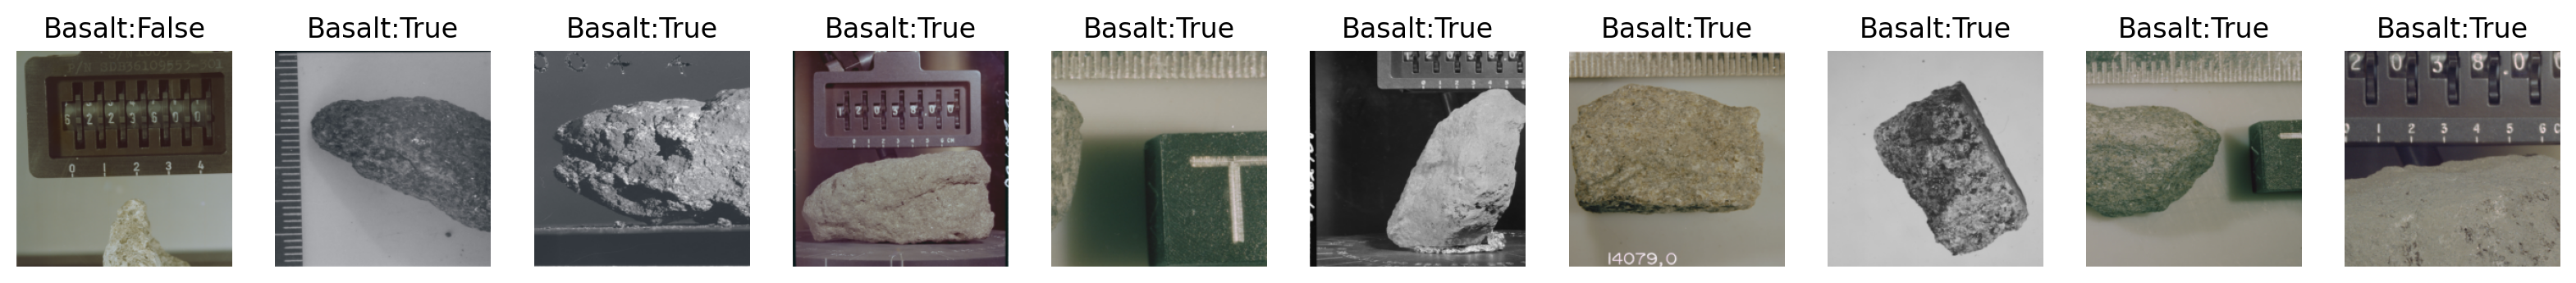

In [38]:
#Test AI model to see how well it predicts rock types correctly

#get five random image and display them in a figure with their labels
to_pil = transforms.ToPILImage()
images, labels = get_random_images(10)
fig = plt.figure(figsize = (20, 10))

#loads all the classes from training loader
classes = trainloader.dataset.classes

#loops through the 5 random selected images 
for ii in range(len(images)):

    #predicts the class of each image
    image = to_pil(images[ii])
    index = predict_image(image)

    #adds the class to the plot graph to display beneath the image
    sub = fig.add_subplot(1, len(images), ii + 1)
    res = int(labels[ii]) == index
    sub.set_title(str(classes[index]) + ":" + str(res))
    plt.axis("off")
    plt.imshow(image)

#reshows the plot with the predicted labels beneath the images 
plt.show()